In [1]:
from asist.utility import power_spectrum, cross_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.signal import detrend
from scipy.stats import beta, skew
from sustain_drag_2020.irgason import rotate
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.dispersion import w2k
import warnings
warnings.filterwarnings('ignore')
import xarray as xr

import matplotlib
font = {'size': 16}
matplotlib.rc('font', **font)

In [2]:
def diffc(x):
    """Finite difference centered in space."""
    xx = np.zeros((x.size))
    xx[1:-1] = (x[2:] - x[:-2]) / 2
    xx[0] = x[1] - x[0]
    xx[-1] = x[-1] - x[-2]
    return xx

# Download and open data

Download the data from https://zenodo.org/record/3827276.

In [3]:
irg = xr.open_dataset('asist-windonly-fresh_irgason.nc')

In [4]:
irg

<xarray.Dataset>
Dimensions:            (Time: 100801)
Coordinates:
  * Time               (Time) float64 0.0 0.05 0.1 ... 5.04e+03 5.04e+03
Data variables:
    fan                (Time) int32 ...
    u                  (Time) float32 ...
    v                  (Time) float32 ...
    w                  (Time) float32 ...
    temperature_sonic  (Time) float32 ...
    temperature_cell   (Time) float32 ...
    pressure_cell      (Time) float32 ...
    relative_humidity  (Time) float32 ...
    flag               (Time) int32 ...
Attributes:
    experiment_name:    asist-windonly-fresh
    experiment_time:    2018-09-26_19:18:00
    instrument:         Campbell Scientific IRGASON
    instrument_fetch:   6.12
    instrument_height:  0.29
    institution:        University of Miami
    facility:           SUSTAIN Laboratory
    tank:               ASIST
    contact:            Milan Curcic <mcurcic@miami.edu>
    notes:              Data with diagnostic flag > 11 have been removed (set...

In [5]:
hf = xr.open_dataset('asist-windonly-fresh_hotfilm.nc')

In [6]:
hf

<xarray.Dataset>
Dimensions:  (Time: 5040000)
Coordinates:
  * Time     (Time) float64 0.0 0.001 0.002 0.003 ... 5.04e+03 5.04e+03 5.04e+03
Data variables:
    fan      (Time) int32 ...
    u        (Time) float32 ...
    w        (Time) float32 ...
Attributes:
    experiment_name:    asist-windonly-fresh
    experiment_time:    2018-09-26_19:18:00
    instrument:         TSI IFA-300 hot film anemometer
    instrument_fetch:   4.66
    instrument_height:  0.29
    institution:        University of Miami
    facility:           SUSTAIN Laboratory
    tank:               ASIST
    contact:            Milan Curcic <mcurcic@miami.edu>

## Raw velocities

### IRGASON

Text(0.5, 0.98, 'IRGASON')

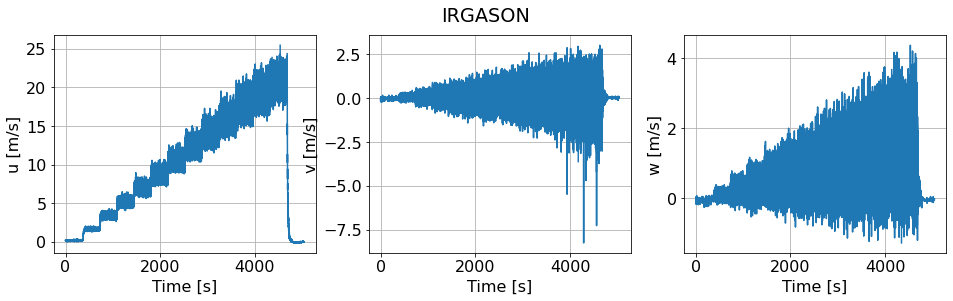

In [7]:
fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(irg.Time, irg.u)
ax2.plot(irg.Time, irg.v)
ax3.plot(irg.Time, irg.w)
ax1.set_ylabel('u [m/s]')
ax2.set_ylabel('v [m/s]')
ax3.set_ylabel('w [m/s]')
for ax in [ax1, ax2, ax3]:
    ax.grid()
    ax.set_xlabel('Time [s]')
fig.suptitle('IRGASON')

## Raw velocities

### IRGASON

Text(0.5, 0.98, 'Hot film')

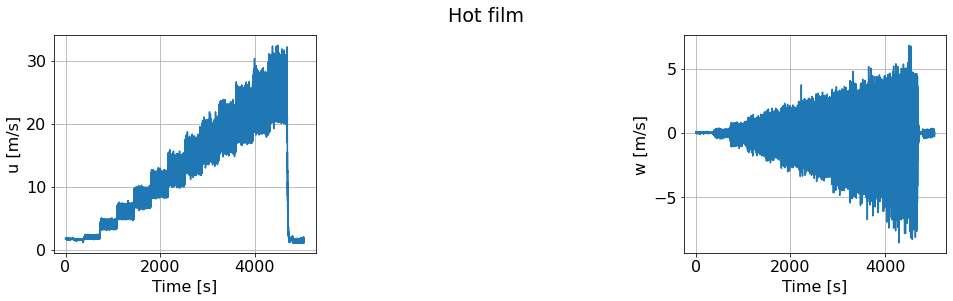

In [8]:
fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax3 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(hf.Time, hf.u)
ax3.plot(hf.Time, hf.w)
ax1.set_ylabel('u [m/s]')
ax3.set_ylabel('w [m/s]')
for ax in [ax1, ax3]:
    ax.grid()
    ax.set_xlabel('Time [s]')
fig.suptitle('Hot film')

## Universal spectra

### IRGASON

In [9]:
run_seconds = 360
offset = 60
z = 0.29
fan = range(5, 50, 5)
nfan = len(fan)
nfreq = 47
Suu = np.zeros((nfan, nfreq))
Sww = np.zeros((nfan, nfreq))
Suw = np.zeros((nfan, nfreq))
U = np.zeros((nfan))
uw = np.zeros((nfan))
sigma_u = np.zeros((nfan))
sigma_w = np.zeros((nfan))

In [10]:
for n, fan_speed in enumerate(fan):
    t0 = (n + 1) * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (irg.Time >= t0) & (irg.Time < t1)
    u, v, w = np.array(irg.u)[mask], np.array(irg.v)[mask], np.array(irg.w[mask]) 
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    if np.any(np.isnan(u)):
        break
    U[n] = np.mean(u)
    up, wp = detrend(u), detrend(w)
    Suu[n,:], Sww[n,:], Suw[n,:], phase, coherence, f, df = cross_spectrum(up, wp, 1 / 20, binsize=64)
    df = diffc(f)[0]
    sigma_u[n], sigma_w[n] = np.std(u), np.std(w)
    uw[n] = np.mean(up * wp)

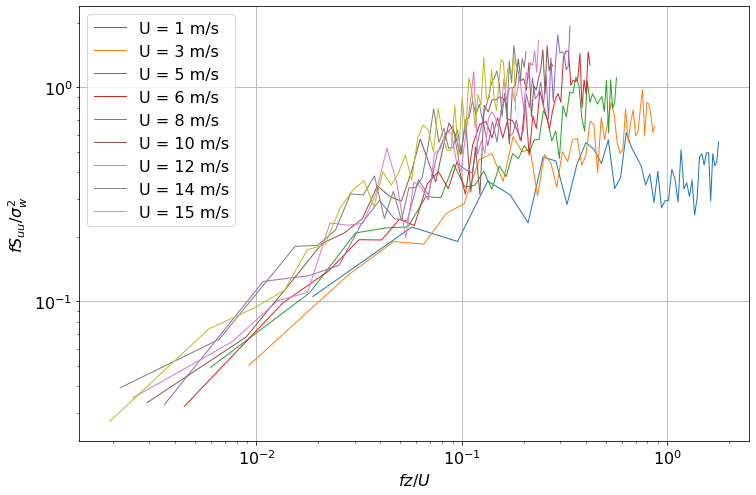

In [11]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.loglog(f * z / U[n], f * Suu[n,:] / sigma_w[n]**2, lw=1, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{uu}/\sigma^2_w$')
plt.grid()

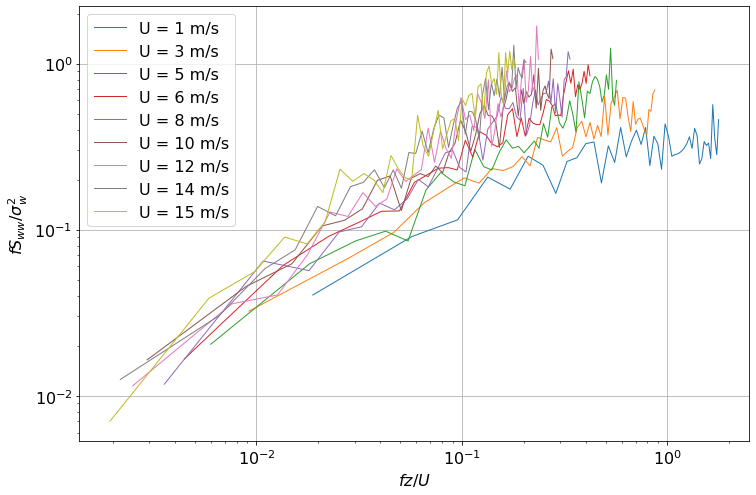

In [12]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.loglog(f * z / U[n], f * Sww[n,:] / sigma_w[n]**2, lw=1, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{ww}/\sigma^2_w$')
plt.grid()

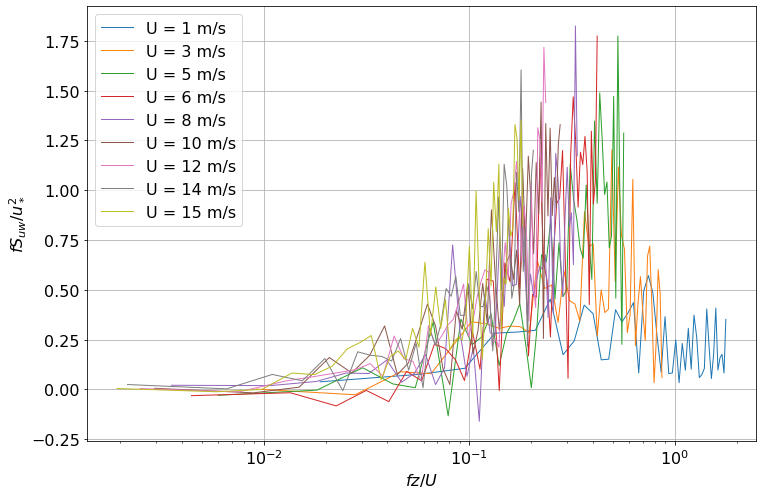

In [13]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.semilogx(f * z / U[n], f * Suw[n,:] / uw[n], lw=1, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{uw}/u^2_*$')
plt.grid()

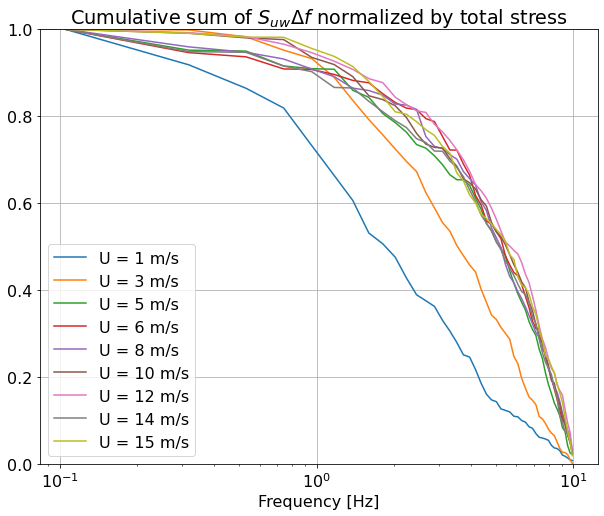

In [14]:
fig = plt.figure(figsize=(10, 8))
for n in range(len(uw)):
    plt.semilogx(f[::-1], np.cumsum(np.abs(Suw[n,::-1]) * df) / np.sum(np.abs(Suw[n,::-1]) * df), label='U = %i m/s' % U[n])
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylim(0, 1)
plt.title('Cumulative sum of $S_{uw} \Delta f$ normalized by total stress')
plt.grid()

### Hot film

In [15]:
run_seconds = 360
offset = 60
z = 0.29
fan = range(5, 50, 5)
nfan = len(fan)
nfreq = 2344
Suu = np.zeros((nfan, nfreq))
Sww = np.zeros((nfan, nfreq))
Suw = np.zeros((nfan, nfreq))
U = np.zeros((nfan))
uw = np.zeros((nfan))
sigma_u = np.zeros((nfan))
sigma_w = np.zeros((nfan))

In [16]:
for n, fan_speed in enumerate(fan):
    t0 = (n + 1) * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (hf.Time >= t0) & (hf.Time < t1)
    u, w = np.array(hf.u)[mask], np.array(hf.w)[mask]
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    if np.any(np.isnan(u)):
        break
    U[n] = np.mean(u)
    up, wp = detrend(u), detrend(w)
    Suu[n,:], Sww[n,:], Suw[n,:], phase, coherence, f, df = cross_spectrum(up, wp, 1 / 1000, binsize=64)
    df = diffc(f)[0]
    sigma_u[n], sigma_w[n] = np.std(u), np.std(w)
    uw[n] = np.mean(up * wp)

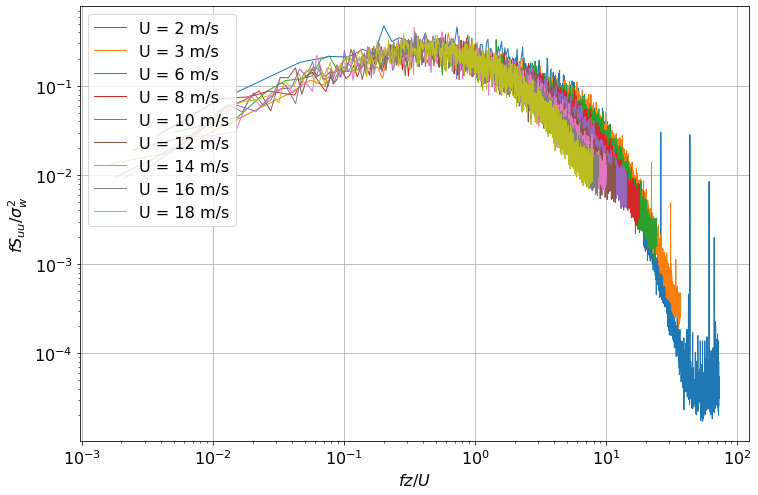

In [17]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.loglog(f * z / U[n], f * Suu[n,:] / sigma_w[n]**2, lw=1, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{uu}/\sigma^2_w$')
plt.grid()

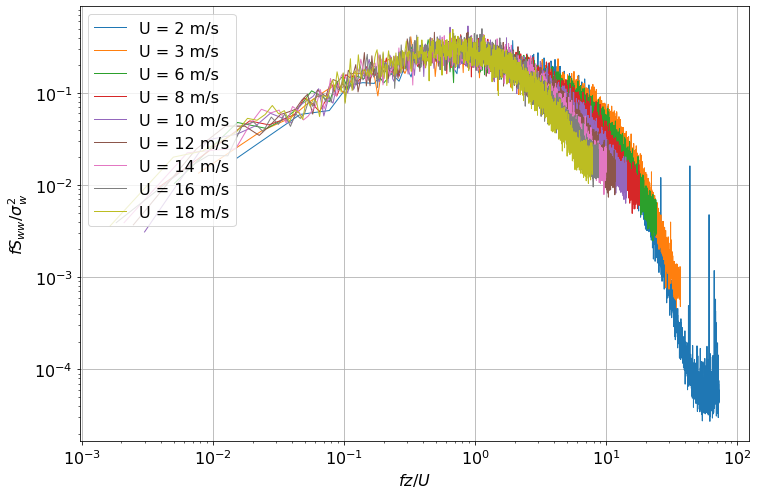

In [18]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    plt.loglog(f * z / U[n], f * Sww[n,:] / sigma_w[n]**2, lw=1, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{ww}/\sigma^2_w$')
plt.grid()

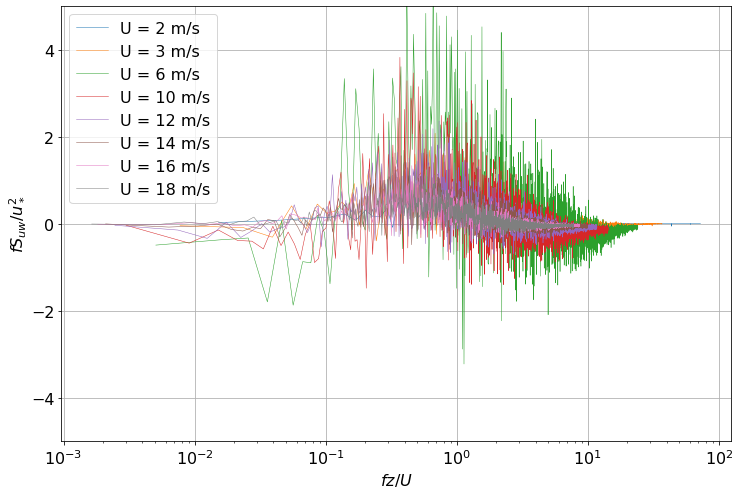

In [19]:
fig = plt.figure(figsize=(12, 8))
for n, fan_speed in enumerate(fan):
    if n == 3:
        continue
    plt.semilogx(f * z / U[n], f * Suw[n,:] / uw[n], lw=0.5, label='U = %i m/s' % U[n])
plt.legend(loc='upper left')
plt.xlabel(r'$fz/U$')
plt.ylabel(r'$f S_{uw}/u^2_*$')
plt.ylim(-5, 5)
plt.grid()

## Velocity distributions

### IRGASON

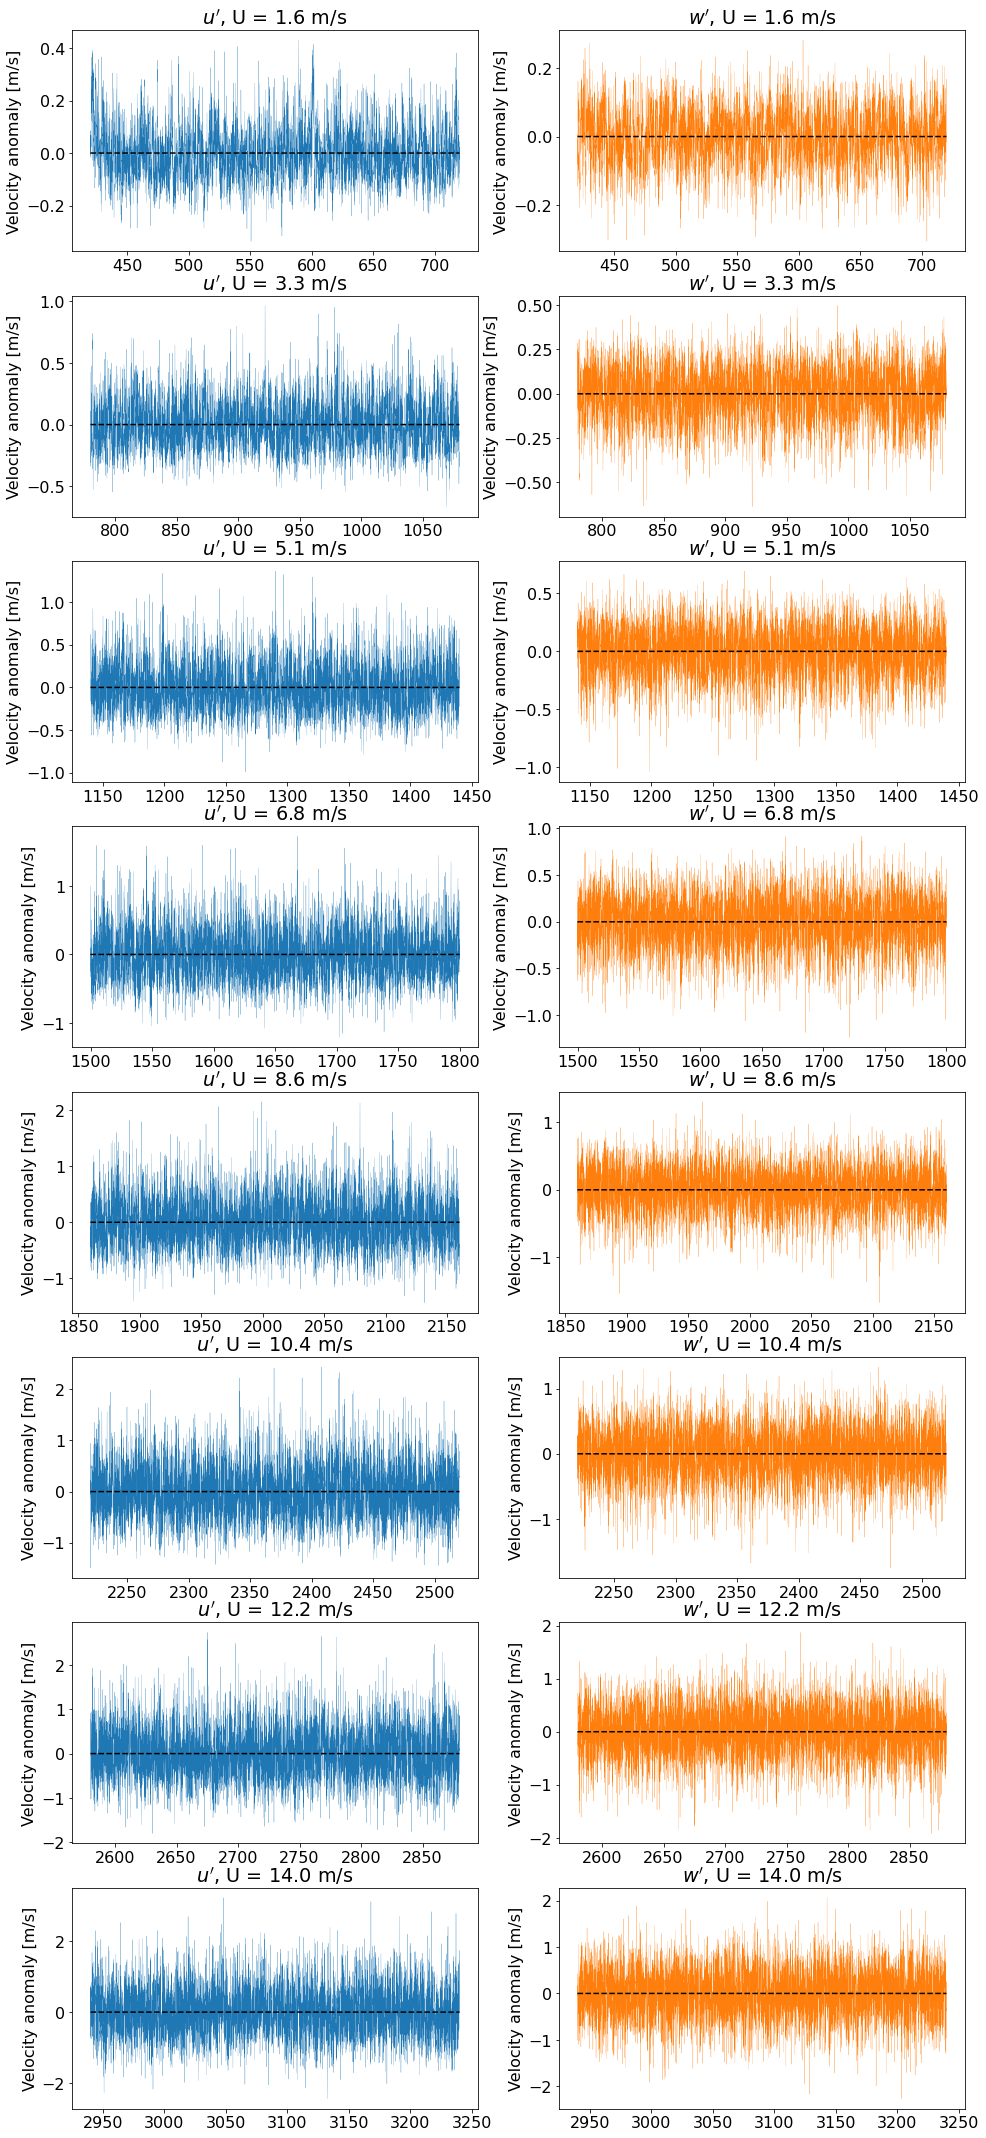

In [20]:
fig = plt.figure(figsize=(16, 48))
for n, fan_speed in enumerate(fan):
    if n == 0:
        continue
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (irg.Time >= t0) & (irg.Time < t1)
    time = irg.Time[mask]
    u, v, w = np.array(irg.u)[mask], np.array(irg.v)[mask], np.array(irg.w[mask]) 
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U = np.mean(u)
    up, wp = detrend(u), detrend(w)
    ax1 = plt.subplot2grid((10, 2), (n-1, 0))
    ax2 = plt.subplot2grid((10, 2), (n-1, 1))
    ax1.plot(time, up, color='tab:blue', lw=0.2)
    ax2.plot(time, wp, color='tab:orange', lw=0.2)
    for ax in [ax1, ax2]:
        ax.set_ylabel('Velocity anomaly [m/s]')
        ax.plot(time, 0 * time, 'k--')
        if n == len(fan) - 1:
            ax.set_ylabel
    ax1.set_title(r"$u'$, U = %.1f m/s" % U)
    ax2.set_title(r"$w'$, U = %.1f m/s" % U)

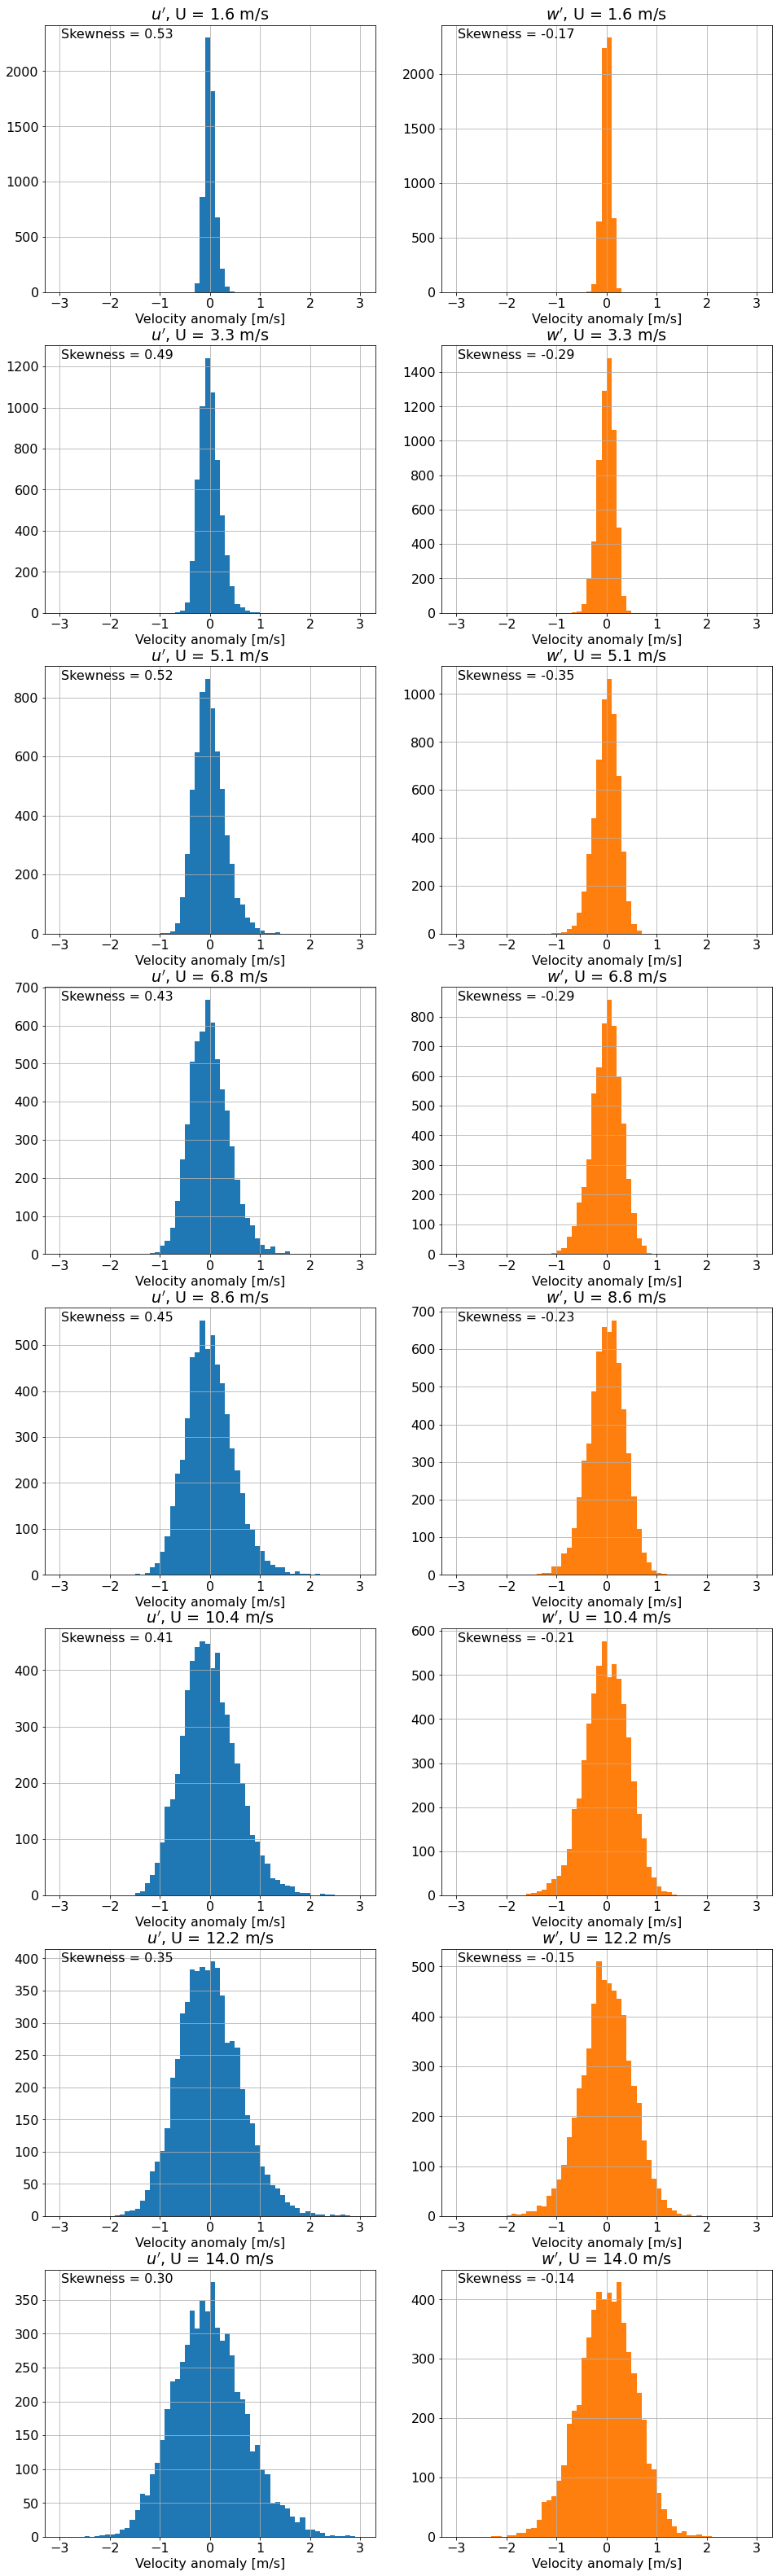

In [21]:
U1, skewu1, skeww1 = [], [], []

fig = plt.figure(figsize=(16, 64))
for n, fan_speed in enumerate(fan):
    if n == 0:
        continue
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (irg.Time >= t0) & (irg.Time < t1)
    time = irg.Time[mask]
    u, v, w = np.array(irg.u)[mask], np.array(irg.v)[mask], np.array(irg.w[mask]) 
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U1.append(np.mean(u))
    up, wp = detrend(u), detrend(w)
    skewu1.append(skew(up))
    skeww1.append(skew(wp))
    ax1 = plt.subplot2grid((9, 2), (n-1, 0))
    ax2 = plt.subplot2grid((9, 2), (n-1, 1))
    ax1.hist(up, bins=np.arange(-3, 3.1, 0.1), color='tab:blue')
    ax2.hist(wp, bins=np.arange(-3, 3.1, 0.1), color='tab:orange')
    ax1.set_title(r"$u'$, U = %.1f m/s" % U1[n-1])
    ax2.set_title(r"$w'$, U = %.1f m/s" % U1[n-1])
    ax1.text(0.05, 0.95, 'Skewness = %.2f' % skew(up), transform=ax1.transAxes)
    ax2.text(0.05, 0.95, 'Skewness = %.2f' % skew(wp), transform=ax2.transAxes)
    for ax in [ax1, ax2]:
        ax.grid()
        ax.set_xlabel('Velocity anomaly [m/s]')

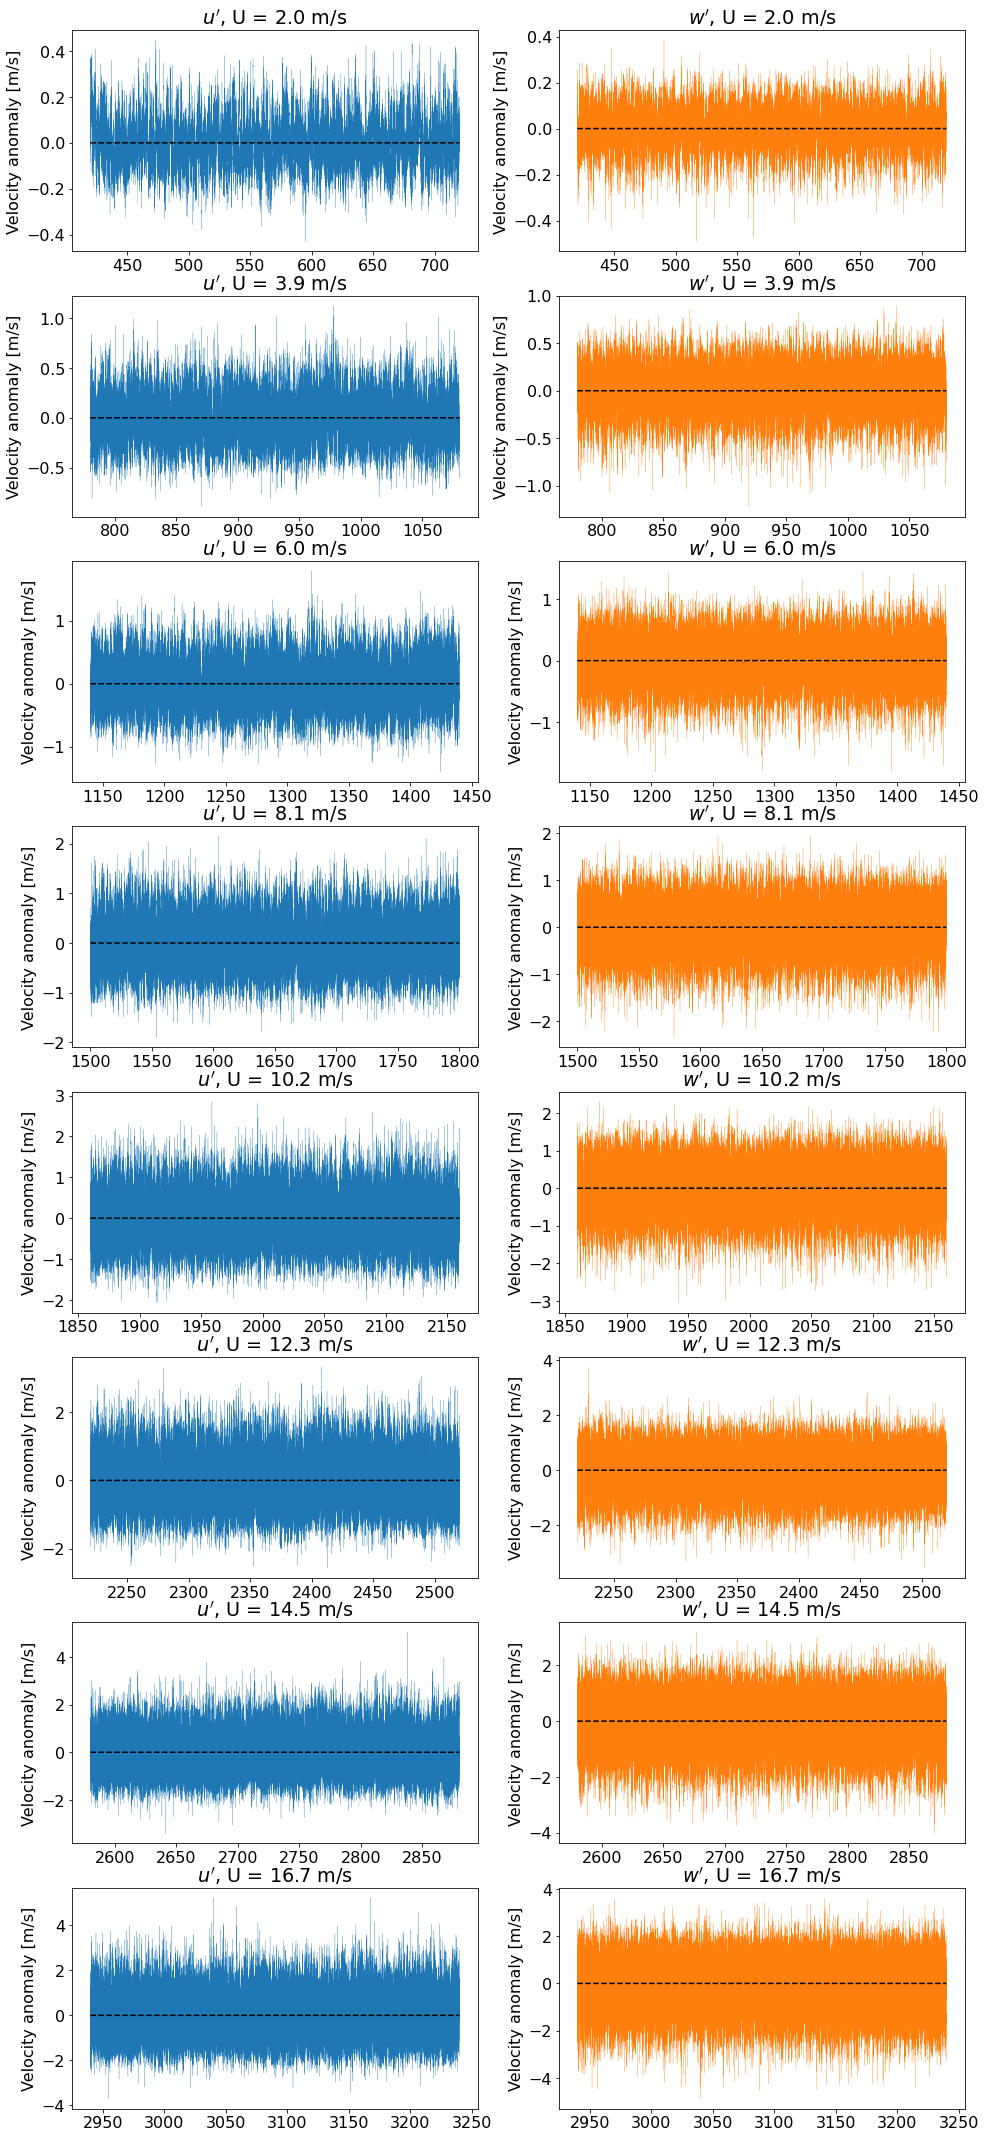

In [22]:
fig = plt.figure(figsize=(16, 48))
for n, fan_speed in enumerate(fan):
    if n == 0:
        continue
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (hf.Time >= t0) & (hf.Time < t1)
    time = hf.Time[mask]
    u, w = np.array(hf.u)[mask], np.array(hf.w[mask]) 
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U = np.mean(u)
    up, wp = detrend(u), detrend(w)
    ax1 = plt.subplot2grid((10, 2), (n-1, 0))
    ax2 = plt.subplot2grid((10, 2), (n-1, 1))
    ax1.plot(time, up, color='tab:blue', lw=0.2)
    ax2.plot(time, wp, color='tab:orange', lw=0.2)
    for ax in [ax1, ax2]:
        ax.set_ylabel('Velocity anomaly [m/s]')
        ax.plot(time, 0 * time, 'k--')
        if n == len(fan) - 1:
            ax.set_ylabel
    ax1.set_title(r"$u'$, U = %.1f m/s" % U)
    ax2.set_title(r"$w'$, U = %.1f m/s" % U)

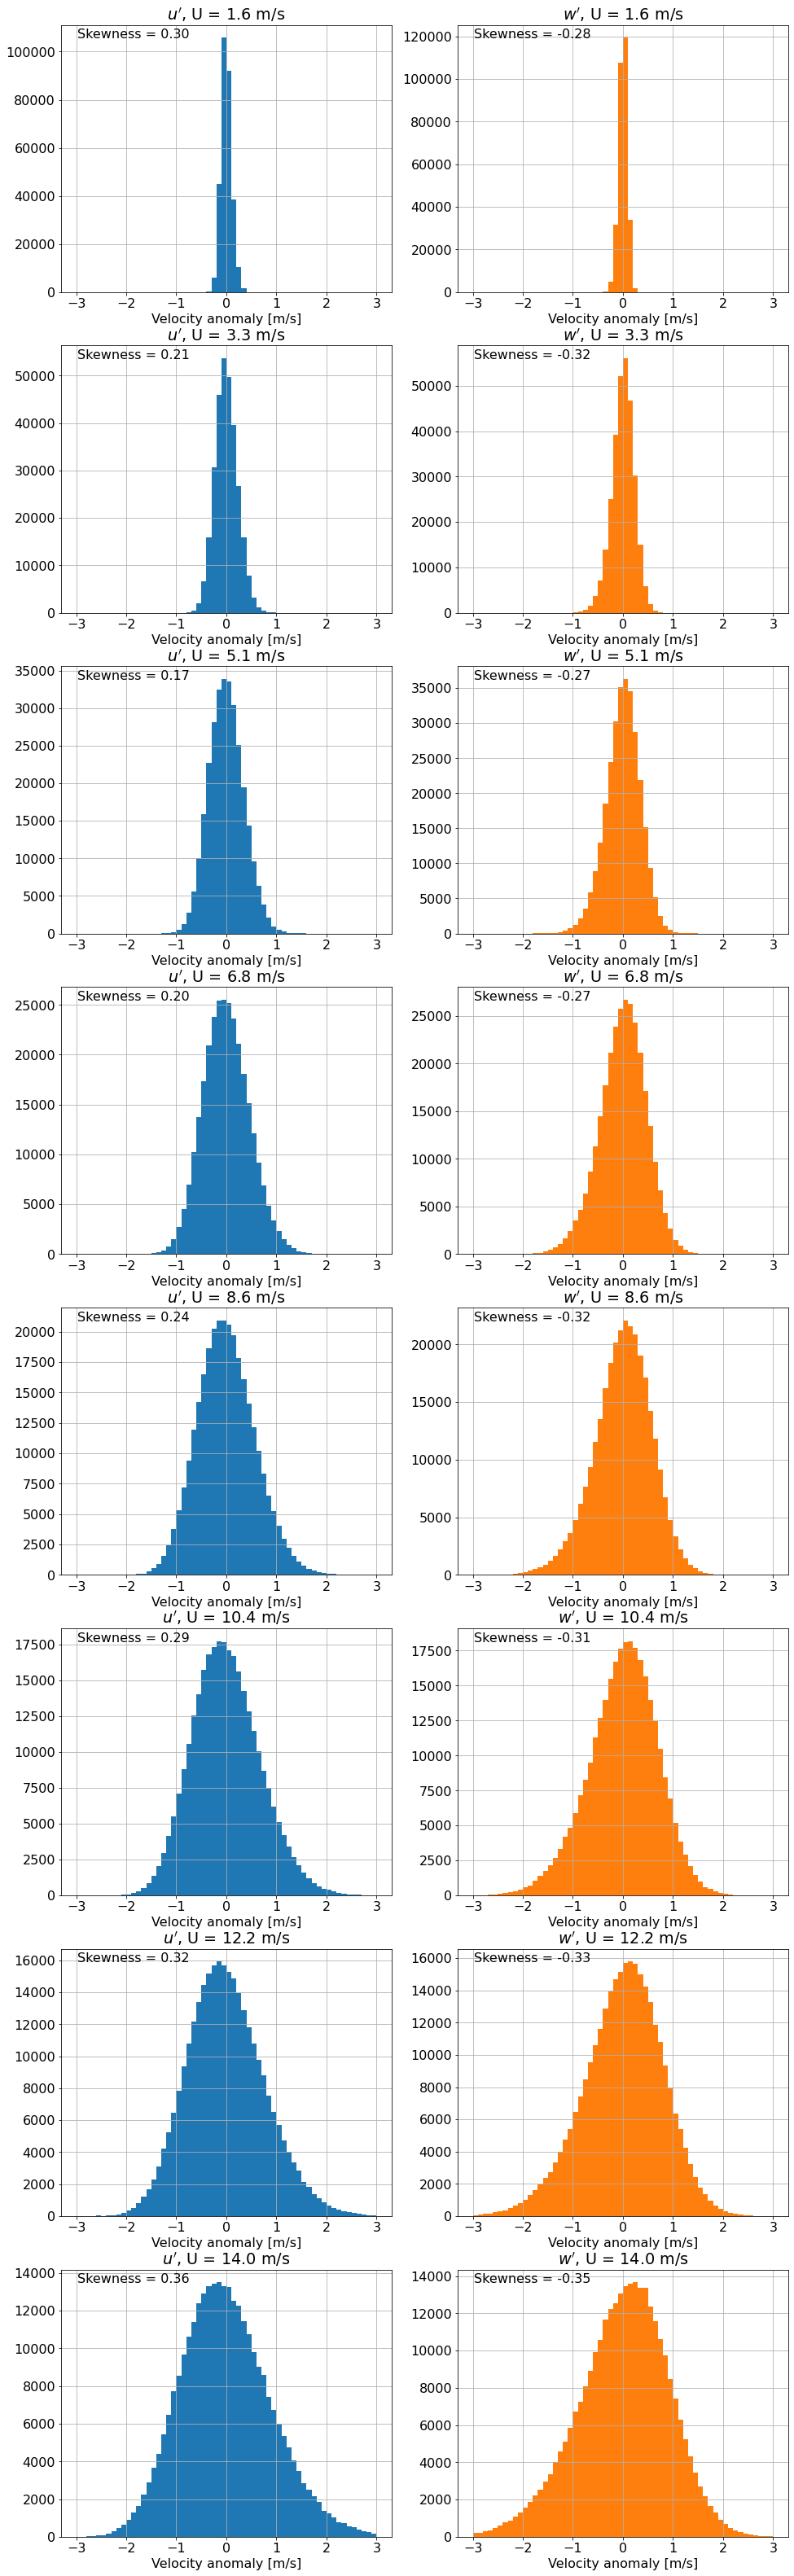

In [23]:
U2, skewu2, skeww2 = [], [], []

fig = plt.figure(figsize=(16, 64))
for n, fan_speed in enumerate(fan):
    if n == 0:
        continue
    t0 = n * run_seconds + offset
    t1 = t0 + run_seconds - offset
    mask = (hf.Time >= t0) & (hf.Time < t1)
    time = hf.Time[mask]
    u, w = np.array(hf.u)[mask], np.array(hf.w[mask]) 
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U2.append(np.mean(u))
    up, wp = detrend(u), detrend(w)
    skewu2.append(skew(up))
    skeww2.append(skew(wp))
    ax1 = plt.subplot2grid((9, 2), (n-1, 0))
    ax2 = plt.subplot2grid((9, 2), (n-1, 1))
    ax1.hist(up, bins=np.arange(-3, 3.1, 0.1), color='tab:blue')
    ax2.hist(wp, bins=np.arange(-3, 3.1, 0.1), color='tab:orange')
    ax1.set_title(r"$u'$, U = %.1f m/s" % U1[n-1])
    ax2.set_title(r"$w'$, U = %.1f m/s" % U1[n-1])
    ax1.text(0.05, 0.95, 'Skewness = %.2f' % skew(up), transform=ax1.transAxes)
    ax2.text(0.05, 0.95, 'Skewness = %.2f' % skew(wp), transform=ax2.transAxes)
    for ax in [ax1, ax2]:
        ax.grid()
        ax.set_xlabel('Velocity anomaly [m/s]')

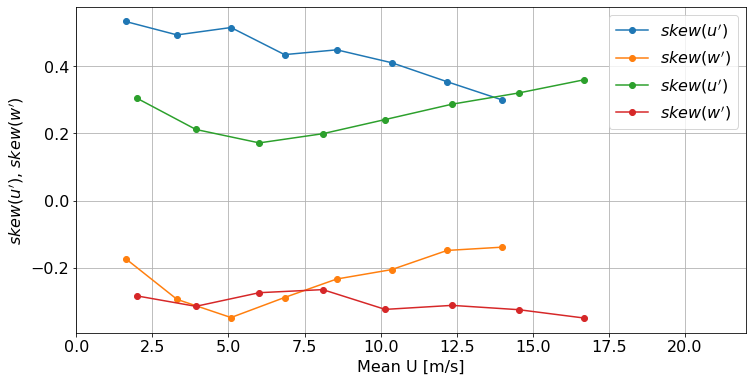

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(U1, skewu1, marker='o', label=r"$skew(u')$")
plt.plot(U1, skeww1, marker='o', label=r"$skew(w')$")
plt.plot(U2, skewu2, marker='o', label=r"$skew(u')$")
plt.plot(U2, skeww2, marker='o', label=r"$skew(w')$")
plt.legend()
plt.xlabel('Mean U [m/s]')
plt.ylabel(r"$skew(u')$, $skew(w')$")
plt.xlim(0, 22)
plt.grid()